In [1]:
from sklearn import manifold, datasets, decomposition
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/Users/anto/.pyenv/versions/tda-project/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
digits = datasets.load_digits(n_class=5)

values = digits.data
labels = digits.target.astype(int).astype(str)

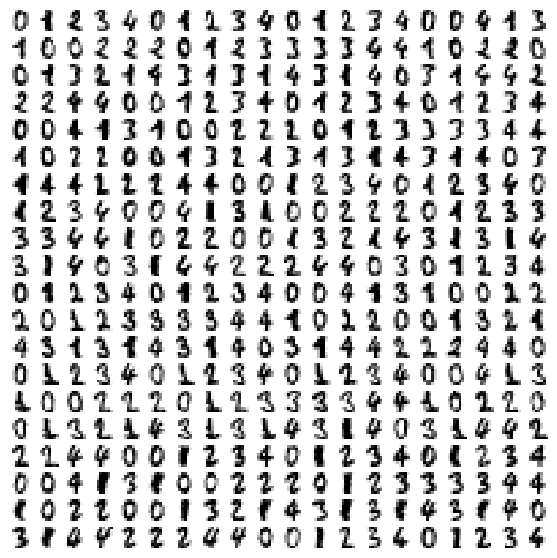

In [3]:
nimg = 20
img  = np.zeros((10 * nimg, 10 * nimg))

for i in range(nimg):
    ix = 10 * i + 1
    for j in range(nimg):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = values[i * nimg + j].reshape((8, 8))

fig, ax = plt.subplots(1, 1, figsize=(10,10))        
  
ax.imshow(img, cmap=plt.cm.binary)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [4]:
X_pca = np.zeros((len(labels),3))
X_mds = X_pca
X_iso = X_pca

# embed in 2D
pca = pd.DataFrame(decomposition.TruncatedSVD(n_components=2).fit_transform(values), columns=['x1','x2'])
mds = pd.DataFrame(manifold.MDS(n_components=2, n_init=1, max_iter=200).fit_transform(values), columns=['x1','x2'])
iso = pd.DataFrame(manifold.Isomap(n_neighbors=20, n_components=2).fit_transform(values), columns=['x1','x2'])

# append labels
pca['digit'] = labels
mds['digit'] = labels
iso['digit'] = labels

In [5]:
pca.head()

,x1,x2,digit
0,45.735821,11.066201,0
1,56.261635,-1.502311,1
2,56.731693,0.455628,2
3,45.507999,-17.043523,3
4,41.678257,23.124095,4


In [6]:
def normalize_embedding(df, dims=['x1','x2']):
    
    # rescale each dimension between [0,1]
    x_min    = df[dims].min() 
    x_max    = df[dims].max()
    df[dims] = (df[dims] - x_min).divide(x_max - x_min)
    
    return df

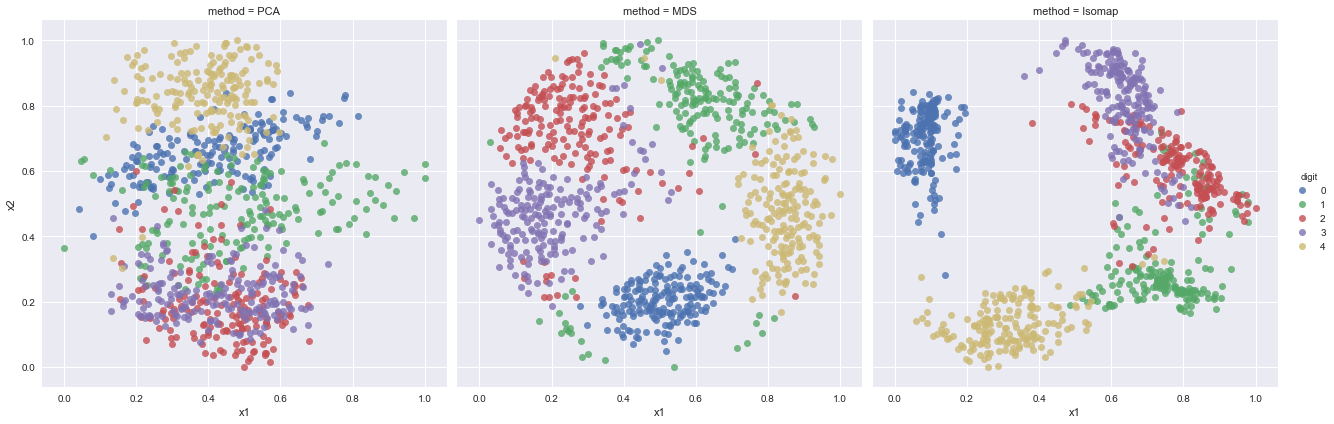

In [8]:
# normalize
pca = normalize_embedding(pca)
mds = normalize_embedding(mds)
iso = normalize_embedding(iso)

# append all embeddings into a labeled dataframe for side-by-side plotting
pca['method'] = 'PCA'
mds['method'] = 'MDS'
iso['method'] = 'Isomap'

sns.lmplot('x1', 'x2', data=pca.append(mds).append(iso), hue='digit', col='method', fit_reg=False, size=6)

In [9]:
import mapper
from scipy.spatial.distance import pdist

Using cmappertools v1.0.24.


In [21]:
# point cloud (64 pixel intensities)
pcd = values

# the metric parameters below specify variance-normalized Euclidean (seuclidean) for the
# dissimilarity metric, where the variance (V) is computed automatically
dist = pdist(pcd, metric='euclidean')

# use normalized embeddings as 2-component filters
filt_pca = pca[['x1','x2']].as_matrix()
filt_mds = mds[['x1','x2']].as_matrix()
filt_iso = iso[['x1','x2']].as_matrix()

# assign the cover for the filter functions
part = mapper.cover.cube_cover_primitive(intervals=25, overlap=50)

# compute the mapper output for each lens (note: using single-linkage clustering default)
result_pca = mapper.mapper(dist, filt_pca, part(filt_pca), cutoff=mapper.cutoff.biggest_gap(), metricpar={}, verbose=False)
result_mds = mapper.mapper(dist, filt_mds, part(filt_mds), cutoff=mapper.cutoff.biggest_gap(), metricpar={}, verbose=False)
result_iso = mapper.mapper(dist, filt_iso, part(filt_iso), cutoff=mapper.cutoff.biggest_gap(), metricpar={}, verbose=False)

Number of observations: 901.
There are 1061 nodes.
Number of observations: 901.
There are 889 nodes.
Number of observations: 901.
There are 585 nodes.


In [22]:
# import visualization utilities from parent directory
import sys

pwd = !pwd
parent_dir = '/'.join(pwd[0].split('/')[:-1])
if parent_dir not in sys.path:
    sys.path.append('/'.join(pwd[0].split('/')[:-1]))

import d3_lib
import tda_mapper_extensions
from IPython.core.display import HTML

In [23]:
pca_encode_digit = pd.get_dummies(pca[['x1','x2','digit']], columns=['digit'], prefix={'digit':'digit'})
mds_encode_digit = pd.get_dummies(mds[['x1','x2','digit']], columns=['digit'], prefix={'digit':'digit'})
iso_encode_digit = pd.get_dummies(iso[['x1','x2','digit']], columns=['digit'], prefix={'digit':'digit'})

# e.g.
iso_encode_digit.head(5)

,x1,x2,digit_0,digit_1,digit_2,digit_3,digit_4
0,0.076970,0.746179,1,0,0,0,0
1,0.733861,0.241827,0,1,0,0,0
2,0.715069,0.359609,0,0,1,0,0
3,0.623277,0.878798,0,0,0,1,0
4,0.235101,0.070986,0,0,0,0,1


In [24]:
G_pca_0 = tda_mapper_extensions.custom_d3js_fdgraph(result_pca, pca_encode_digit, feature='digit_0')
G_pca_1 = tda_mapper_extensions.custom_d3js_fdgraph(result_pca, pca_encode_digit, feature='digit_1')
G_pca_2 = tda_mapper_extensions.custom_d3js_fdgraph(result_pca, pca_encode_digit, feature='digit_2')
G_pca_3 = tda_mapper_extensions.custom_d3js_fdgraph(result_pca, pca_encode_digit, feature='digit_3')
G_pca_4 = tda_mapper_extensions.custom_d3js_fdgraph(result_pca, pca_encode_digit, feature='digit_4')

G_mds_0 = tda_mapper_extensions.custom_d3js_fdgraph(result_mds, mds_encode_digit, feature='digit_0')
G_mds_1 = tda_mapper_extensions.custom_d3js_fdgraph(result_mds, mds_encode_digit, feature='digit_1')
G_mds_2 = tda_mapper_extensions.custom_d3js_fdgraph(result_mds, mds_encode_digit, feature='digit_2')
G_mds_3 = tda_mapper_extensions.custom_d3js_fdgraph(result_mds, mds_encode_digit, feature='digit_3')
G_mds_4 = tda_mapper_extensions.custom_d3js_fdgraph(result_mds, mds_encode_digit, feature='digit_4')

G_iso_0 = tda_mapper_extensions.custom_d3js_fdgraph(result_iso, iso_encode_digit, feature='digit_0')
G_iso_1 = tda_mapper_extensions.custom_d3js_fdgraph(result_iso, iso_encode_digit, feature='digit_1')
G_iso_2 = tda_mapper_extensions.custom_d3js_fdgraph(result_iso, iso_encode_digit, feature='digit_2')
G_iso_3 = tda_mapper_extensions.custom_d3js_fdgraph(result_iso, iso_encode_digit, feature='digit_3')
G_iso_4 = tda_mapper_extensions.custom_d3js_fdgraph(result_iso, iso_encode_digit, feature='digit_4')

In [25]:
HTML(d3_lib.set_styles('force_directed') +
     '<script src="http://d3js.org/d3.v3.min.js"></script>' +
     '<script src="http://marvl.infotech.monash.edu/webcola/cola.v3.min.js"></script>' +
     d3_lib.draw_graph('force_directed', {'data': G_iso_4}))